<a href="https://colab.research.google.com/github/ajainf/AI_Energy/blob/main/Part_3_XGboost_Model_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create an XGBoost Model for Energy Star Score Prediction

Goal: Create an ML model to predict Energy Star Score including information from buildings and from satellite thermal imagery

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1 # necessary to use specific packages to avoid an error warning about sklearn tags

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import shap
import seaborn as sns

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Merge and Clean up**

In [ ]:
folder = r'/content/drive/MyDrive/ai_energy_capstone_schools'

bldg = pd.read_csv(folder + r'/data_sf_open_data/SF_BuildingFootprints_Energy_Simpler.csv')


In [ ]:
thermal = pd.read_csv(folder + r'/data_thermal/thermal_df2.csv')

In [ ]:
print(bldg.shape)
print(thermal.shape)

(22284, 45)
(854, 8)


In [ ]:
filter1 = bldg[~bldg['ENERGY STAR Score'].isna()]
filter2 = filter1[filter1['Benchmark Year']==2018]

print(filter1.shape)
print(filter2.shape)

(8211, 45)
(854, 45)


In [ ]:
thermal.columns

Index(['Unnamed: 0', 'unique_ide', 'mean_lst', 'max_lst', 'min_lst', 'sd_lst',
       'latitude', 'longitude'],
      dtype='object')

In [ ]:
bldg_data = filter2
bldg_data.rename(columns={'unique_identifier':'unique_ide'}, inplace=True)
print(bldg_data.columns)

Index(['Unnamed: 0', 'hgt_cells50cm', 'hgt_mincm', 'hgt_maxcm', 'hgt_rangecm',
       'hgt_meancm', 'hgt_stdcm', 'hgt_varietycm', 'hgt_majoritycm',
       'hgt_minoritycm', 'hgt_mediancm', 'gnd_min_m', 'median_1st_m',
       'hgt_median_m', 'shape', 'unique_ide', 'Parcel Number', 'Building Name',
       'Building Address', 'Postal Code', 'Floor Area', 'Category',
       'Property Type - Self Selected', 'PIM Link', 'Year Built',
       'Benchmark Year', 'ENERGY STAR Score', 'Site EUI (kBtu/ft2)',
       'Source EUI (kBtu/ft2)', 'Percent Better than National Median Site EUI',
       'Weather Normalized Site EUI (kBtu/ft2)',
       'Weather Normalized Source EUI (kBtu/ft2)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Total GHG Emissions Intensity (kGCO2e/ft2)',
       'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (kBtu)',
       'District Steam Use (kBtu)', 'Site Energy Use (kBtu)',
       'Benchmark Status', 'Reason for Exemption', 'point', 'longitude',
       '

<ipython-input-9-7909ac24e2f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bldg_data.rename(columns={'unique_identifier':'unique_ide'}, inplace=True)


In [ ]:
data = bldg_data.merge(thermal, on='unique_ide', how='left')
data.columns

Index(['Unnamed: 0_x', 'hgt_cells50cm', 'hgt_mincm', 'hgt_maxcm',
       'hgt_rangecm', 'hgt_meancm', 'hgt_stdcm', 'hgt_varietycm',
       'hgt_majoritycm', 'hgt_minoritycm', 'hgt_mediancm', 'gnd_min_m',
       'median_1st_m', 'hgt_median_m', 'shape', 'unique_ide', 'Parcel Number',
       'Building Name', 'Building Address', 'Postal Code', 'Floor Area',
       'Category', 'Property Type - Self Selected', 'PIM Link', 'Year Built',
       'Benchmark Year', 'ENERGY STAR Score', 'Site EUI (kBtu/ft2)',
       'Source EUI (kBtu/ft2)', 'Percent Better than National Median Site EUI',
       'Weather Normalized Site EUI (kBtu/ft2)',
       'Weather Normalized Source EUI (kBtu/ft2)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Total GHG Emissions Intensity (kGCO2e/ft2)',
       'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (kBtu)',
       'District Steam Use (kBtu)', 'Site Energy Use (kBtu)',
       'Benchmark Status', 'Reason for Exemption', 'point', 'longitude_x',
    

In [ ]:
print(data.shape)
print(data.columns)

(854, 52)
Index(['Unnamed: 0_x', 'hgt_cells50cm', 'hgt_mincm', 'hgt_maxcm',
       'hgt_rangecm', 'hgt_meancm', 'hgt_stdcm', 'hgt_varietycm',
       'hgt_majoritycm', 'hgt_minoritycm', 'hgt_mediancm', 'gnd_min_m',
       'median_1st_m', 'hgt_median_m', 'shape', 'unique_ide', 'Parcel Number',
       'Building Name', 'Building Address', 'Postal Code', 'Floor Area',
       'Category', 'Property Type - Self Selected', 'PIM Link', 'Year Built',
       'Benchmark Year', 'ENERGY STAR Score', 'Site EUI (kBtu/ft2)',
       'Source EUI (kBtu/ft2)', 'Percent Better than National Median Site EUI',
       'Weather Normalized Site EUI (kBtu/ft2)',
       'Weather Normalized Source EUI (kBtu/ft2)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Total GHG Emissions Intensity (kGCO2e/ft2)',
       'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (kBtu)',
       'District Steam Use (kBtu)', 'Site Energy Use (kBtu)',
       'Benchmark Status', 'Reason for Exemption', 'point', 'longitud

In [ ]:
data.head(4)

,Unnamed: 0_x,hgt_cells50cm,hgt_mincm,hgt_maxcm,hgt_rangecm,hgt_meancm,hgt_stdcm,hgt_varietycm,hgt_majoritycm,hgt_minoritycm,hgt_mediancm,gnd_min_m,median_1st_m,hgt_median_m,shape,unique_ide,Parcel Number,Building Name,Building Address,Postal Code,Floor Area,Category,Property Type - Self Selected,PIM Link,Year Built,Benchmark Year,ENERGY STAR Score,Site EUI (kBtu/ft2),Source EUI (kBtu/ft2),Percent Better than National Median Site EUI,Weather Normalized Site EUI (kBtu/ft2),Weather Normalized Source EUI (kBtu/ft2),Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kGCO2e/ft2),Electricity Use - Grid Purchase (kWh),Natural Gas Use (kBtu),District Steam Use (kBtu),Site Energy Use (kBtu),Benchmark Status,Reason for Exemption,point,longitude_x,latitude_x,analysis_neighborhood,supervisor_district,Unnamed: 0_y,mean_lst,max_lst,min_lst,sd_lst,latitude_y,longitude_y
0,3,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,"MULTIPOLYGON (((-122.477349923 37.728902496, -...",7296/006_2018,7296/006,Nordstrom,285 WINSTON DR,94132,176000,Retail Store,Commercial,https://sfplanninggis.org/PIM/?tab=Property&se...,1988.0,2018,75.0,41.8,100.1,-0.246,41.8,100.1,488.5,2.8,1656830.9,1700377.6,NaN,7353485.5,2018 - Complied,NaN,POINT (-122.477538393 37.726530193),-122.477538,37.726530,Lakeshore,7.0,0,299.734242,299.734242,299.734242,0.000012,37.726530,-122.477538
1,6,93580,125,2373,2248,972.429269,160.114620,1353,1011,125,1003,8.83,19.76,10.03,"MULTIPOLYGON (((-122.411785124 37.707158737, -...",6309/004A_2018,6309/004A,333 SCHWERIN ST,333 SCHWERIN ST,94134,274000,Non-Refrigerated Warehouse,Commercial,https://sfplanninggis.org/PIM/?tab=Property&se...,1955.0,2018,24.0,22.3,52.2,0.576,22.5,52.3,402.8,1.5,1318795.1,1615291.0,NaN,6115020.5,2018 - Complied,NaN,POINT (-122.411118123 37.708785431),-122.411118,37.708785,Visitacion Valley,10.0,1,301.881531,302.959768,300.159360,1.347124,37.708785,-122.411118
2,13,69665,842,5184,4342,3925.339467,304.479051,2133,3771,842,3796,8.38,48.30,37.96,"MULTIPOLYGON (((-122.406333907 37.784927301, -...",3705/052_2018,3705/052,72022A (SAN FRANCISCO CENTRE),845 MARKET ST,94103,337000,Retail Store,Commercial,https://sfplanninggis.org/PIM/?tab=Property&se...,2006.0,2018,28.0,62.2,174.1,0.248,62.3,174.4,1475.9,4.4,6140616.2,10.0,NaN,20951794.9,2018 - Complied,NaN,POINT (-122.40614459 37.784100395),-122.406145,37.784100,South of Market,6.0,2,301.346710,301.327004,301.327004,0.000007,37.784100,-122.406145
3,26,52322,110,2706,2596,2053.761725,218.577245,1743,2009,110,2034,1.89,24.62,20.34,"MULTIPOLYGON (((-122.403069115 37.771704553, -...",3783/009_2018,3783/009,650 Townsend - Zynga,699 8TH ST,94103,1029659,Office,Commercial,https://sfplanninggis.org/PIM/?tab=Property&se...,1990.0,2018,89.0,58.2,153.1,-0.350,58.2,153.1,2870.8,4.0,11044306.1,4073952.6,NaN,41757129.5,2018 - Complied,NaN,POINT (-122.403546253 37.771022012),-122.403546,37.771022,South of Market,6.0,3,303.886388,303.886388,303.886388,0.000000,37.771022,-122.403546


In [ ]:

# Drop columns that are unlikely related to target
data = data.drop(['PIM Link','Building Address','Building Name','Benchmark Status', 'Reason for Exemption','point', 'Unnamed: 0_x', 'Unnamed: 0_y', 'latitude_y','longitude_x'], axis=1)
print(data.shape)

(854, 42)


In [ ]:
data.head()

,hgt_cells50cm,hgt_mincm,hgt_maxcm,hgt_rangecm,hgt_meancm,hgt_stdcm,hgt_varietycm,hgt_majoritycm,hgt_minoritycm,hgt_mediancm,gnd_min_m,median_1st_m,hgt_median_m,shape,unique_ide,Parcel Number,Postal Code,Floor Area,Category,Property Type - Self Selected,Year Built,Benchmark Year,ENERGY STAR Score,Site EUI (kBtu/ft2),Source EUI (kBtu/ft2),Percent Better than National Median Site EUI,Weather Normalized Site EUI (kBtu/ft2),Weather Normalized Source EUI (kBtu/ft2),Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kGCO2e/ft2),Electricity Use - Grid Purchase (kWh),Natural Gas Use (kBtu),District Steam Use (kBtu),Site Energy Use (kBtu),latitude_x,analysis_neighborhood,supervisor_district,mean_lst,max_lst,min_lst,sd_lst,longitude_y
0,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,"MULTIPOLYGON (((-122.477349923 37.728902496, -...",7296/006_2018,7296/006,94132,176000,Retail Store,Commercial,1988.0,2018,75.0,41.8,100.1,-0.246,41.8,100.1,488.5,2.8,1656830.9,1700377.6,NaN,7353485.5,37.726530,Lakeshore,7.0,299.734242,299.734242,299.734242,0.000012,-122.477538
1,93580,125,2373,2248,972.429269,160.114620,1353,1011,125,1003,8.83,19.76,10.03,"MULTIPOLYGON (((-122.411785124 37.707158737, -...",6309/004A_2018,6309/004A,94134,274000,Non-Refrigerated Warehouse,Commercial,1955.0,2018,24.0,22.3,52.2,0.576,22.5,52.3,402.8,1.5,1318795.1,1615291.0,NaN,6115020.5,37.708785,Visitacion Valley,10.0,301.881531,302.959768,300.159360,1.347124,-122.411118
2,69665,842,5184,4342,3925.339467,304.479051,2133,3771,842,3796,8.38,48.30,37.96,"MULTIPOLYGON (((-122.406333907 37.784927301, -...",3705/052_2018,3705/052,94103,337000,Retail Store,Commercial,2006.0,2018,28.0,62.2,174.1,0.248,62.3,174.4,1475.9,4.4,6140616.2,10.0,NaN,20951794.9,37.784100,South of Market,6.0,301.346710,301.327004,301.327004,0.000007,-122.406145
3,52322,110,2706,2596,2053.761725,218.577245,1743,2009,110,2034,1.89,24.62,20.34,"MULTIPOLYGON (((-122.403069115 37.771704553, -...",3783/009_2018,3783/009,94103,1029659,Office,Commercial,1990.0,2018,89.0,58.2,153.1,-0.350,58.2,153.1,2870.8,4.0,11044306.1,4073952.6,NaN,41757129.5,37.771022,South of Market,6.0,303.886388,303.886388,303.886388,0.000000,-122.403546
4,49589,45,1593,1548,979.139406,287.086891,1308,674,45,1158,4.66,17.39,11.58,"MULTIPOLYGON (((-122.407765963 37.771746814, -...",3781/003_2018,3781/003,94103,257165,Strip Mall,Commercial,1991.0,2018,92.0,49.5,135.5,-0.408,49.7,135.7,514.8,3.5,2082219.2,269803.2,NaN,7374336.1,37.771028,South of Market,6.0,303.921241,303.926868,303.886388,0.015086,-122.407314


In [ ]:
# dropping NANs
data = data[~data['ENERGY STAR Score'].isna()]
print(data.shape)

(854, 42)


In [ ]:
cols_of_interest = ['longitude_y','latitude_x','analysis_neighborhood',
                    'mean_lst', 'max_lst', 'min_lst', 'sd_lst',
                    'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (kBtu)','Site Energy Use (kBtu)',
                    'Site EUI (kBtu/ft2)', 'Source EUI (kBtu/ft2)', 'Total GHG Emissions (Metric Tons CO2e)',
                    'Floor Area', 'Category','Property Type - Self Selected', 'Year Built',
                    'hgt_median_m','ENERGY STAR Score','shape']

In [ ]:
dataIn=data[cols_of_interest].drop('shape',axis=1)

In [ ]:
import geopandas as gpd


from shapely import wkt
# Convert the 'shape' column to actual Shapely geometry objects
data['shape'] = data['shape'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(data[cols_of_interest], geometry='shape', crs='epsg:4326')

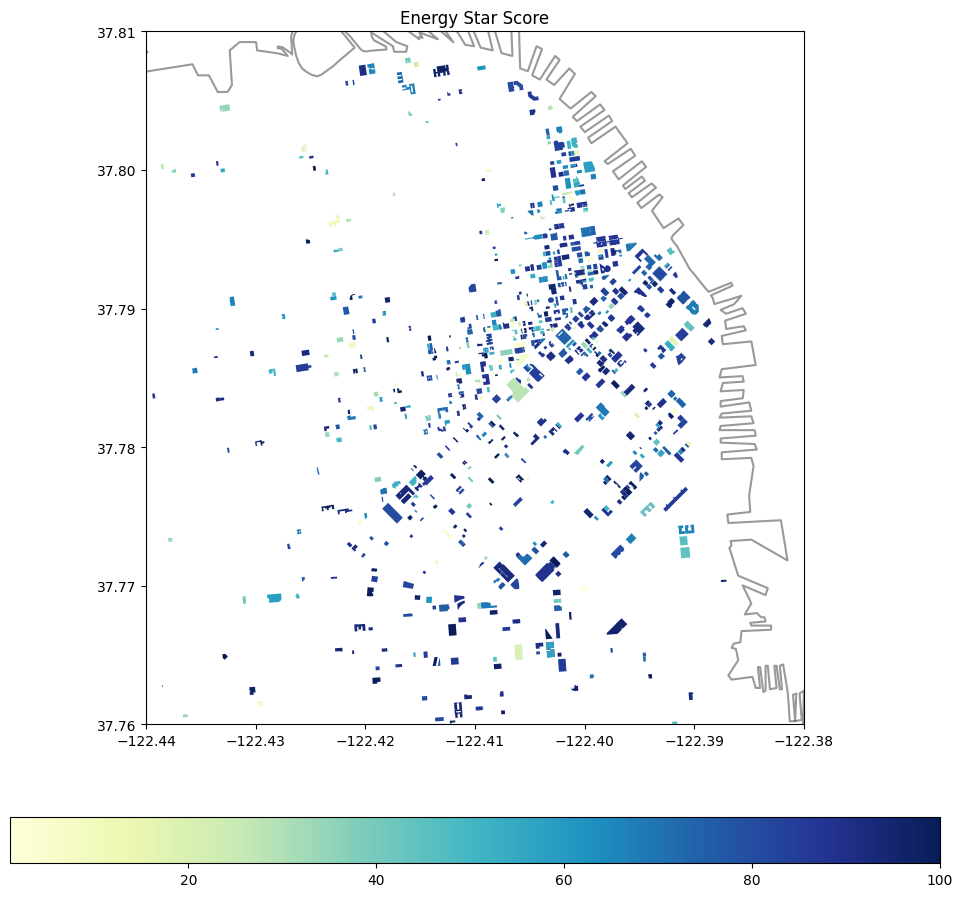

In [ ]:
import matplotlib.pyplot as plt

# Boundary
sf_boundary = gpd.read_file(folder+r'/data_sf_boundary/SF_county_only.shp')

# create an Axes object and plot the map
fig, ax = plt.subplots(figsize=(12, 12))
sf_boundary.boundary.plot(ax=ax, color='black', alpha=0.4)
gdf.plot('ENERGY STAR Score', ax=ax, cmap='YlGnBu', legend=True, legend_kwds={"orientation": "horizontal", "pad": 0.1})
#gdf.plot('Total GHG Emissions (Metric Tons CO2e)', ax=ax, cmap='YlGnBu', legend=True, legend_kwds={"orientation": "horizontal", "pad": 0.1})

#All SF
#ax.set_xlim(-122.52, -122.35)
#ax.set_ylim(37.70, 37.82)

#Zoom In
ax.set_xlim(-122.44, -122.38)
ax.set_ylim(37.76, 37.81)
plt.title('Energy Star Score')
#plt.title('Total GHG Emissions (Metric Tons CO2e)')
plt.show()

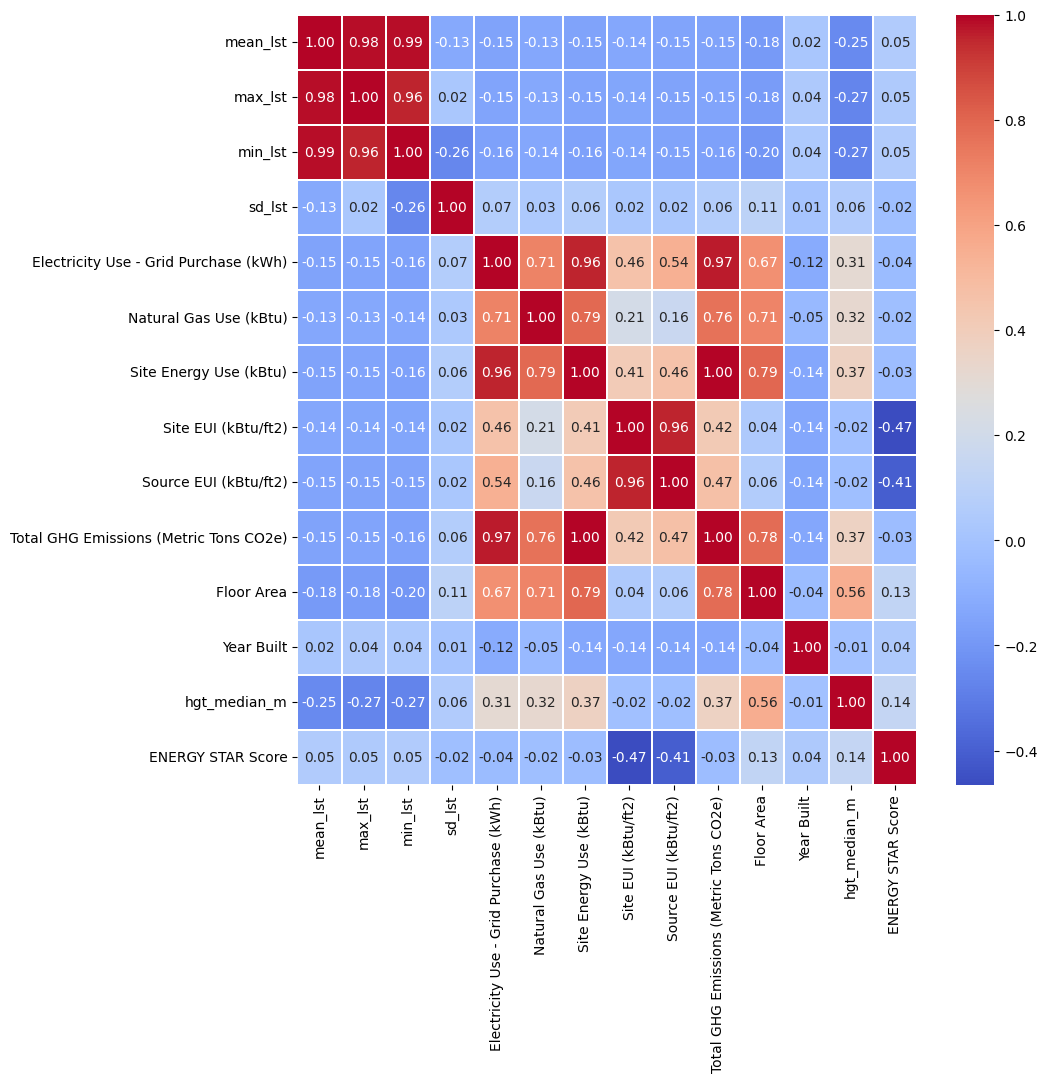

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
##set up the parameters
rcParams['figure.figsize'] = 80,50
rcParams['font.size'] = 10

plotdata = dataIn[ [ 'mean_lst', 'max_lst', 'min_lst', 'sd_lst', # Satellite Data
                    'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (kBtu)','Site Energy Use (kBtu)',
                    'Site EUI (kBtu/ft2)', 'Source EUI (kBtu/ft2)','Total GHG Emissions (Metric Tons CO2e)',
                    'Floor Area', 'Year Built', # SF Open Energy Building Ordinance
                    'hgt_median_m','ENERGY STAR Score']]


# Calculate and plot the correlation
sns.heatmap(plotdata.corr(), annot = True, cmap = 'coolwarm', linewidths = 0.1, annot_kws = {'size':10}, fmt = '.2f')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

In [ ]:
df_nan = (dataIn.isnull().sum() / len(dataIn)) * 100
missing_data = pd.DataFrame({'Missing n':dataIn.isnull().sum(),'% Missing' :df_nan})
missing_data.sort_values('% Missing', ascending=False).head(20)

,Missing n,% Missing
Natural Gas Use (kBtu),124,14.519906
max_lst,115,13.466042
min_lst,115,13.466042
sd_lst,115,13.466042
Year Built,14,1.639344
Site Energy Use (kBtu),4,0.468384
Electricity Use - Grid Purchase (kWh),4,0.468384
Site EUI (kBtu/ft2),2,0.234192
Source EUI (kBtu/ft2),2,0.234192
Total GHG Emissions (Metric Tons CO2e),2,0.234192


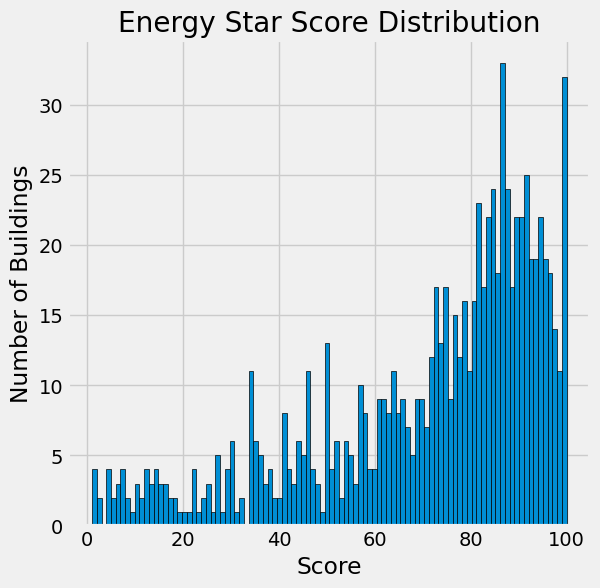

In [ ]:
# Histogram of the Energy Star Score
plt.figure(figsize=(6,6))
plt.style.use('fivethirtyeight')
plt.hist(dataIn['ENERGY STAR Score'], bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Number of Buildings');
plt.title('Energy Star Score Distribution');

array(['Retail Store', 'Non-Refrigerated Warehouse', 'Office',
       'Strip Mall', 'Distribution Center', 'Multifamily Housing',
       'Hotel', 'Wholesale Club/Supercenter', 'Supermarket/Grocery Store',
       'Mixed Use Property', 'Hospital (General Medical & Surgical)',
       'Performing Arts', 'Data Center', 'Other',
       'Refrigerated Warehouse', 'Worship Facility', 'Medical Office',
       'K-12 School', 'Manufacturing/Industrial Plant',
       'Other - Services', 'Parking', 'Financial Office',
       'Outpatient Rehabilitation/Physical Therapy', 'Food Service',
       'College/University', 'Fitness Center/Health Club/Gym',
       'Bank Branch', nan, 'Senior Living Community', 'Laboratory'],
      dtype=object)

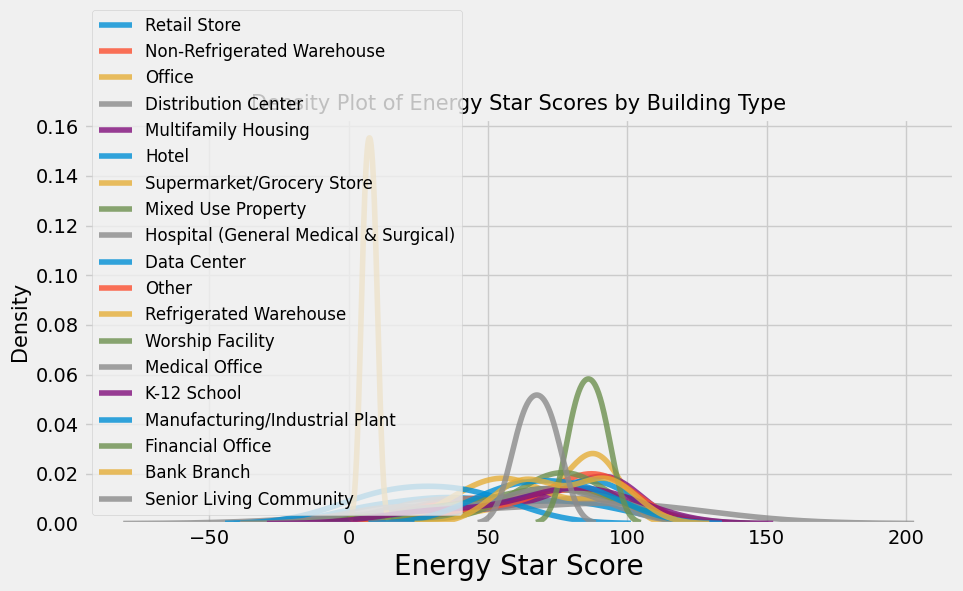

In [ ]:
# Plot of distribution of scores for building categories
plt.figure(figsize=(10, 5))
types = dataIn['Category'].unique()

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Category'] == b_type]

    # Density plot of Energy Star scores
    sns.kdeplot(subset['ENERGY STAR Score'],label = b_type, alpha = 0.8);

# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 15);
plt.title('Density Plot of Energy Star Scores by Building Type', size = 15);
plt.legend(fontsize = 12, loc='center left', bbox_to_anchor=(1, 0.5))

# **XGBOOST**

XGBoost is a decision-tree–based, ensemble machine learning algorithm based on gradient boosting.

We will use it to try to predict the Energy Star Score and understand what factors are important in the model

scikit-learn can be used for hyperparameter tuning

 https://xgboosting.com/explain-xgboost-like-im-5-years-old-eli5/

In [ ]:
# Separate the features and target
target = 'ENERGY STAR Score'
X = dataIn.drop(target, axis=1)
y = dataIn[target]

# Split the data into training/test sets, reserving 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Designate categorical values
cats =['Category','Property Type - Self Selected', 'analysis_neighborhood']
for item in cats:
  X_train[item] = X_train[item].astype("category")
  X_test[item] = X_test[item].astype("category")

In [ ]:
#check again the data size after dropping the 'Id' variable
print("\nTrain shape : {} ".format(X_train.shape))
print("Test shape : {} ".format(X_test.shape))


Train shape : (683, 18) 
Test shape : (171, 18) 


**Parameter Tuning**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

hyperparameter_grid = {
    'model__n_estimators': [100, 400, 800],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.05, 0.1, 0.20],
    }

pipeline = RandomizedSearchCV(
    Pipeline(steps=[("model", xgb.XGBRegressor(objective= 'reg:squarederror',
                      enable_categorical=True, seed = 0))
                    ]),
    param_distributions=hyperparameter_grid,
    n_iter=20,
    scoring='r2',
    n_jobs=-1,
    cv=7,
    verbose=3)

In [ ]:
pipeline.fit(X_train, y_train)

Fitting 7 folds for each of 20 candidates, totalling 140 fits


RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=True,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constra...
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.05, 0.1,
                                                                 0.2],
                                        'model__max_depth': [3, 6, 9],
                                        'model__n_estimators': [100, 400, 800]},
                   scoring='r2', verbose=3)

In [ ]:
hyperparam = pipeline.best_params_
print("The best Hyperparameters for XGBRegressor are: {}".format(hyperparam))

The best Hyperparameters for XGBRegressor are: {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1}


In [ ]:
print("Accuracy = {} ".format(pipeline.score(X_test, y_test)))

Accuracy = 0.3408375153823957 


In [ ]:
# Train a model using the scikit-learn API parameters

model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror',
                     tree_method='hist', enable_categorical=True)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

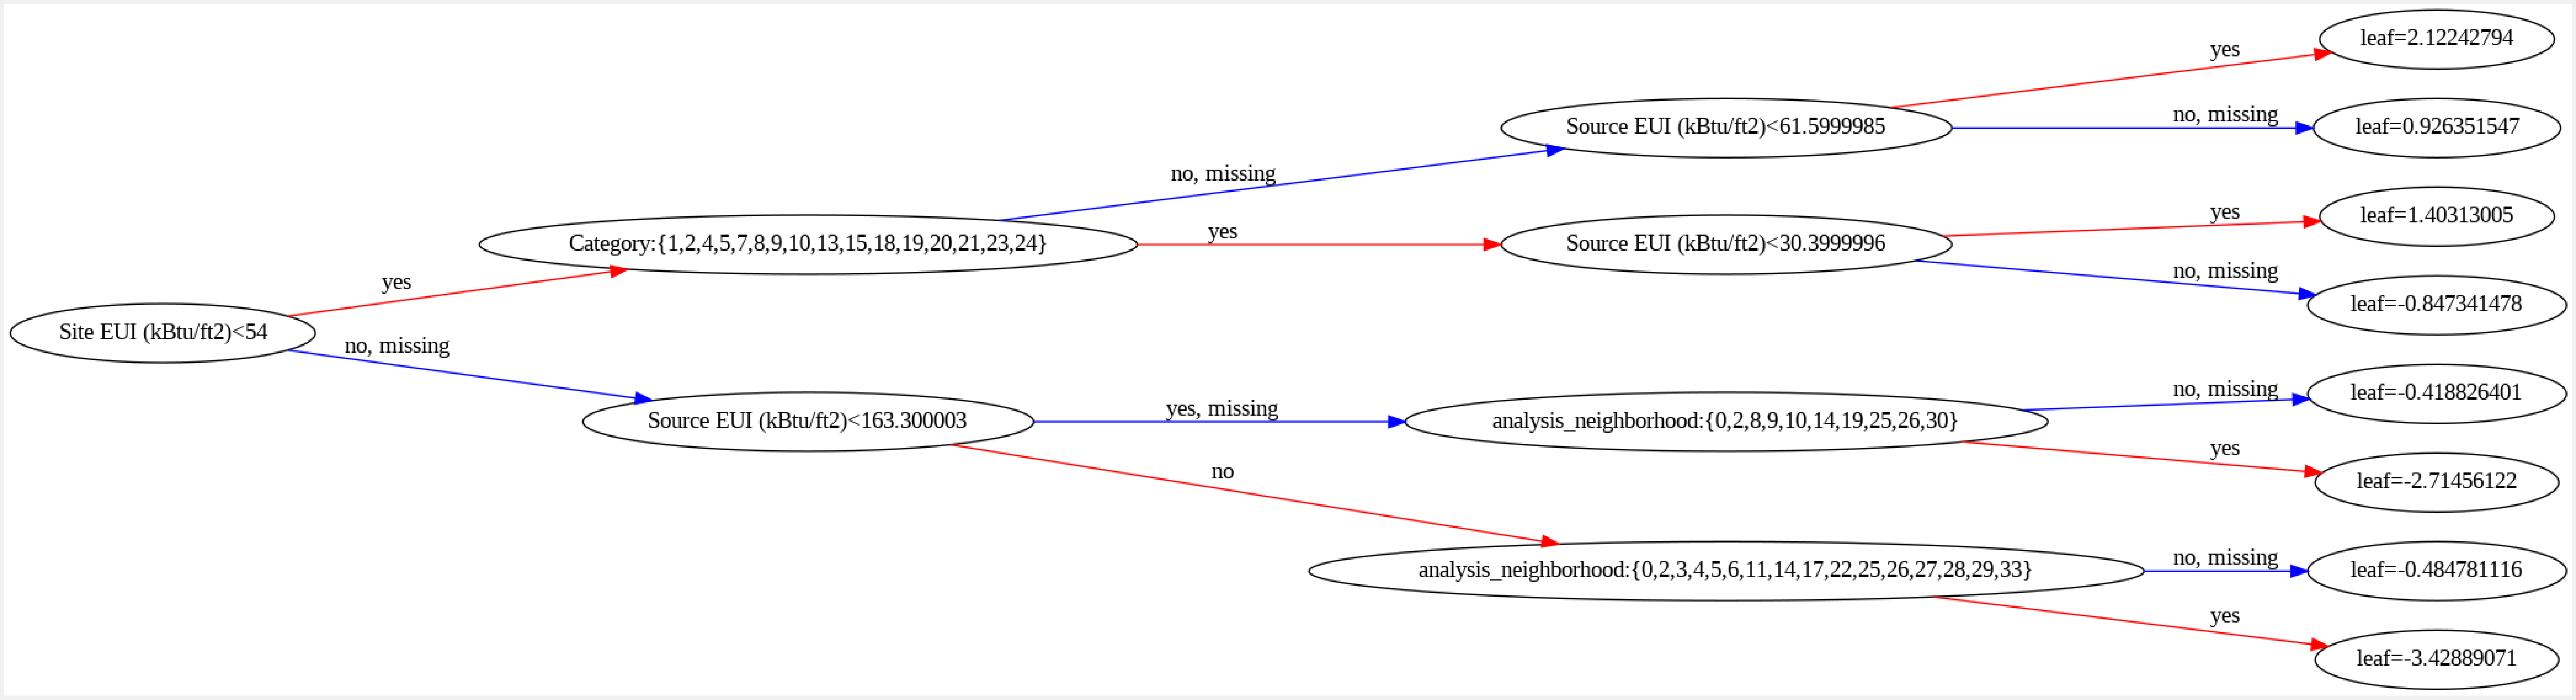

In [ ]:
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50
rcParams['font.size'] = 22
xgb.plot_tree(model, num_trees=0, rankdir='LR')  # Visualize the first tree in the ensemble



In [ ]:
# Model has been trained, lets test it
# Make predictions with the test set
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([ 64.80569 ,  69.79219 ,  78.66457 ,  50.305073,  80.904396,
        56.885654,  57.25444 ,  71.19791 ,  76.27154 ,  71.77063 ,
        67.091064,  79.60748 ,  52.693806,  89.07318 ,  88.28824 ,
        57.188766,  64.30899 ,  70.63123 ,  60.20158 ,  91.450714,
        64.69445 ,  61.938683,  52.69717 ,  55.940086,  79.23947 ,
        62.839886,  65.14739 ,  39.80043 ,  85.35171 ,  77.24346 ,
        90.58963 ,  83.21414 ,  59.589462,  87.090805,  50.834053,
        54.79298 ,  61.15828 ,  64.946396,  61.646465,  80.796875,
        35.562878,  87.20449 ,  63.80012 ,  48.984486,  55.758587,
        53.49697 ,  35.296165,  87.94184 ,  85.50457 ,  79.77963 ,
        66.92433 ,  56.298103,  68.0334  ,  47.95473 ,  28.33168 ,
        77.229904,  71.12584 ,  67.03647 ,  58.238144,  69.1759  ,
        59.225555,  45.616344,  62.50405 ,  86.24533 ,  57.45703 ,
        61.14762 ,  78.72848 ,  64.67213 ,  81.23101 ,  51.999367,
       102.21703 ,  57.052498,  71.12515 ,  71.9928  ,  78.054

In [ ]:
# Evaluate the RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print("Root Mean Squared Error : " + str(rmse)+" and R2: "+ str(r2))

# for continous variables use MAE
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(y_pred, y_test)))

Root Mean Squared Error : 22.417432421400136 and R2: 0.3408375153823957
Mean Absolute Error : 17.707085553665607


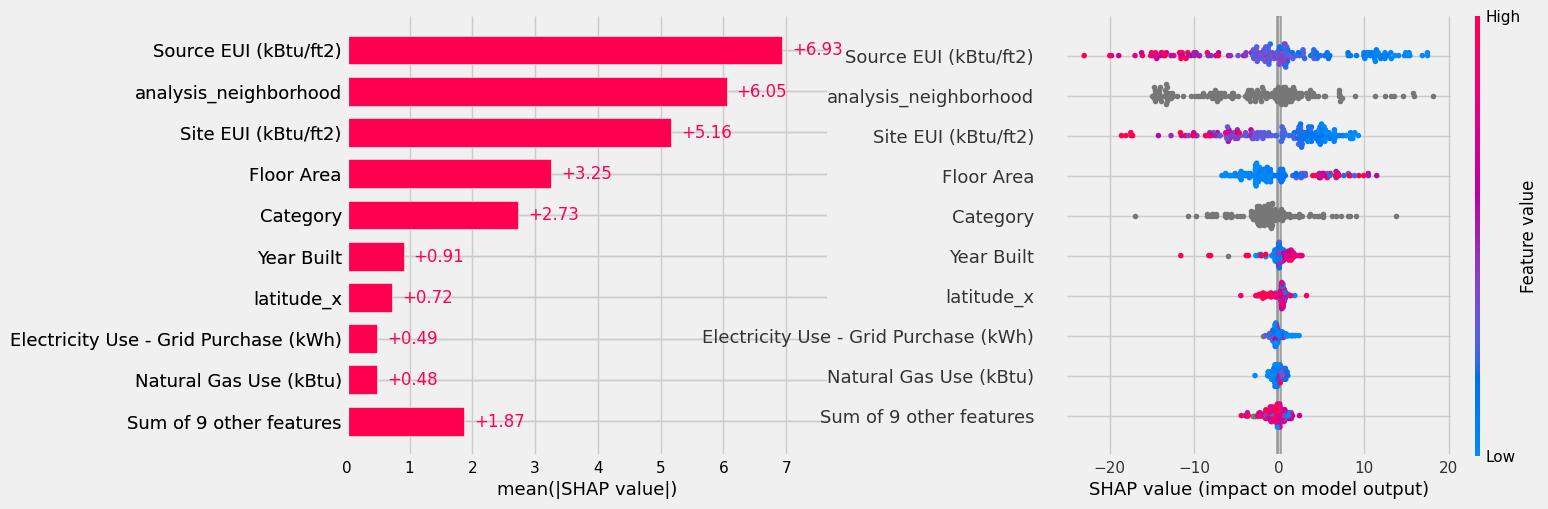

In [ ]:
## Understand what was important to the model using SHAP

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Create a SHAP bar and beeswarm plot
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
shap.plots.bar(shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(shap_values, max_display=10, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1,
    right=2.5,
    top=0.9,
    wspace = 0.5)

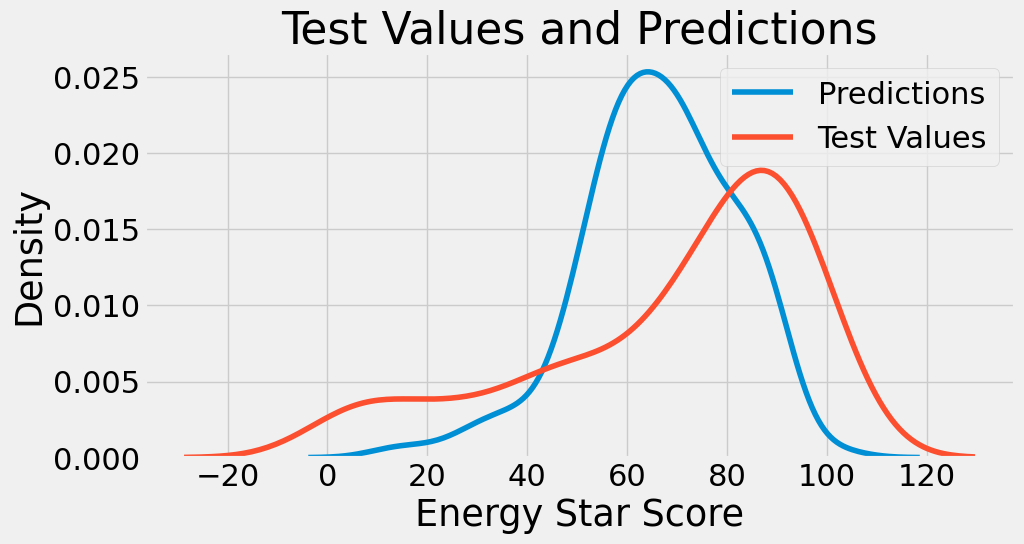

In [ ]:

plt.figure(figsize=(10, 5))

# Density plot of the final predictions and the test values
sns.kdeplot(y_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Test Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');
plt.legend()

Text(0.5, 1.0, 'Energy Star Score')

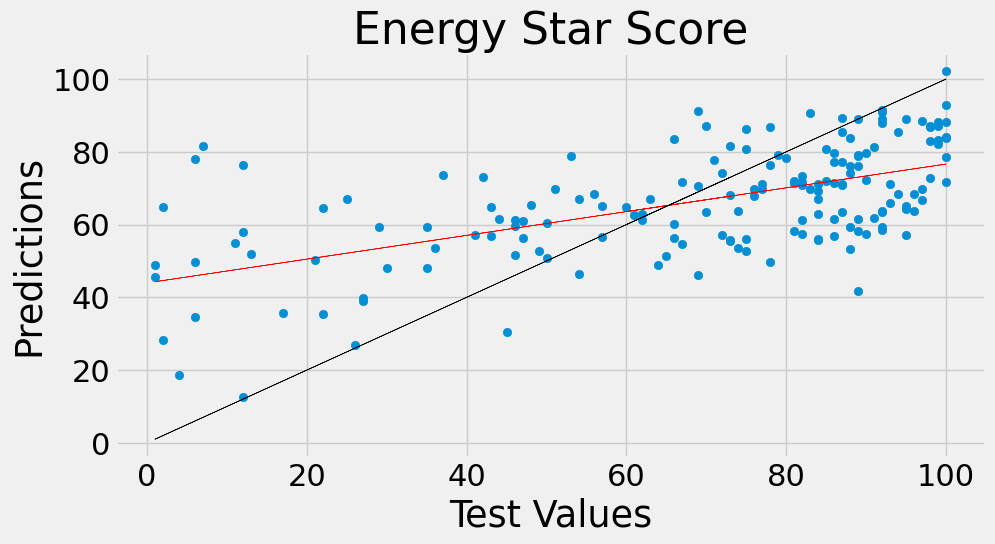

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)

import numpy as np
# Calculate the line of best fit
x= y_test
y= y_pred
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

plt.plot(x, line, color='red', label='Line of Best Fit', linewidth=0.5)


# Define the slope and intercept
line1To1 = 1 * x
plt.plot(x, line1To1, color='black', label='Line 1:1', linewidth=0.5)

plt.xlabel('Test Values')
plt.ylabel('Predictions')
plt.title('Energy Star Score')